<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-и-изучение-данных" data-toc-modified-id="Загрузка-и-изучение-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка и изучение данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

**Цель исследования:**  

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:**  

Обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок. Значение метрики качества *F1* должно быть не меньше 0.75

**Описание данных:**

Данные находятся в файле `toxic_comments.csv`.  
Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак.

## Подготовка

### Импорт библиотек

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

import random
from numpy.random import RandomState
import warnings
warnings.filterwarnings('ignore')
import sklearn
import time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.utils import shuffle

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier 
from sklearn.dummy import DummyClassifier

import spacy
import string
import torch
from tqdm import tqdm
tqdm.pandas()
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

RND = 12345

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Загрузка и изучение данных

In [3]:
try:
    df = pd.read_csv('/Users/galina/Desktop/учёба/спринт 13. Машиное обучение для текстов/toxic_comments.csv') 
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


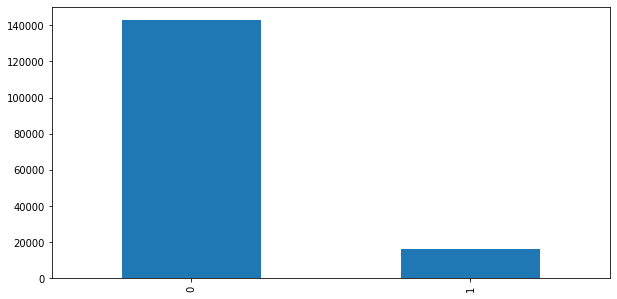

In [6]:
# посмотрим, сколько в выбрке токсичных/нектоксичных текстов
df['toxic'].value_counts().plot.bar(figsize=(10, 5))
plt.show()

In [7]:
# Проверим наличие дубликатов
df.duplicated().sum()

0

In [8]:
# Проверим наличие пропусков
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

*Первичный анализ:*

- В данных 159292 строки
- В столбце text содержатся тексты твитов на английском, есть лишние знаки типа "\nMore\n
- В столбе toxic булевые значения, является ли данный твит токсичным или нет
- 90% твитов отрицательного класса, необходимо учесть дисбаланс при обучении моделей
- Необходимо избавиться от столбца Unnamed, так как он фактически дублирует индексы
- Явных дубликатов и пропусков нет

### Подготовка данных

Удаляем столбец Unnamed: 0

In [9]:
df = df.drop(['Unnamed: 0'], axis=1)

Функция очистки текста (приводим текст к нижнему регистру, оставляем буквы, кавычки и пробелы)

In [10]:
def clear_text(text):
    clear_text = text.lower()
    clear_text = re.sub(r'[^a-zA-Z]', ' ', clear_text)   
    clear_text = ' '.join(clear_text.split())
    return clear_text

Для лемматизации используем  библиотеку SpaCy 

In [11]:
def lemmatize_spacy(text, lemmatizer):
    doc = lemmatizer(text)
    lemm_text = " ".join([token.lemma_ for token in doc])
        
    return lemm_text

Очищаем текст от лишних символов

In [12]:
tqdm.pandas()
df['text'] = df['text'].progress_apply(clear_text)
df.head()

100%|██████████| 159292/159292 [00:04<00:00, 32564.90it/s]


,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


 Лемматизируем текст

In [13]:
tqdm.pandas()

sp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

df['text'] = df['text'].progress_apply(lemmatize_spacy, lemmatizer=sp)

100%|██████████| 159292/159292 [17:56<00:00, 148.00it/s]


In [14]:
df.sample(5)

,text,toxic
38940,linear b write pelasgian language if linear b ...,0
73723,I agree with csloat except that if palin have ...,0
42127,a ha you re a virgin aren t you that s get to ...,0
19957,hi thank for email I delete your article becau...,0
110264,race of final fantasy have actually be split b...,0


Разделим датасет на выборки в соотношении 90/10 в соответствии с дисбалансом классов

In [15]:
features = df.drop(['toxic'], axis=1) 
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=.1, 
                                                                              random_state=RND,
                                                                            stratify=target)


In [16]:
print(features_train.shape)
print(target_train.shape)
print()

print(features_test.shape)
print(target_test.shape)

(143362, 1)
(143362,)

(15930, 1)
(15930,)


In [17]:
features_train = features_train.text

**ВЫВОД**

В процессе подготовки данных мы:
- удалили не информативный столбец
- привели к нижнему регистру
- очистили данные от лишних символов, оставили только буквы, кавычки и пробелы
- лемматизировали текст, используя библиотеку SpaCy. Техника POS-tag (part-of-speech) в spacy используется по умолчанию.

## Обучение

### LogisticRegression

In [18]:
%%time

#обучение:
pipeline = Pipeline([("vect", TfidfVectorizer(stop_words='english', sublinear_tf=True)), 
                     ("lr", LogisticRegression())])
    
parameters = {'lr__solver': ('liblinear', 'saga','newton-cg', 'lbfgs'),
              'lr__C': (.1, 1, 5, 10),
              'lr__random_state': ([12345]),
              'lr__max_iter': ([200]),
              'lr__class_weight': (['balanced'])} 

lr_gscv = GridSearchCV(pipeline, parameters, scoring='f1', cv=3, n_jobs=-1)

lr_gscv.fit(features_train, target_train)

mts = lr_gscv.cv_results_['mean_test_score']
lr_train_f1 = max(mts)

print('F1 логистической регрессии =', round(lr_train_f1,2))
print('при параметрах', lr_gscv.best_params_)


F1 логистической регрессии = 0.77
при параметрах {'lr__C': 10, 'lr__class_weight': 'balanced', 'lr__max_iter': 200, 'lr__random_state': 12345, 'lr__solver': 'liblinear'}
CPU times: user 15min 12s, sys: 11min 27s, total: 26min 40s
Wall time: 26min 42s


### RandomForestClassifier

In [19]:
%%time

#обучение:
pipeline = Pipeline([("vect", TfidfVectorizer(stop_words='english')), 
                     ("rf", RandomForestClassifier())])
    
parameters = {'rf__n_estimators': ([x for x in range(10, 30)]),
              'rf__random_state': ([12345]),
              'rf__max_depth': ([x for x in range(1, 10)]),
              'rf__criterion': (['entropy']),
              'rf__class_weight': (['balanced'])}

rf_gscv = GridSearchCV(pipeline, parameters, scoring='f1', cv=3, n_jobs=-1)

rf_gscv.fit(features_train, target_train)

mts = rf_gscv.cv_results_['mean_test_score']
rf_train_f1 = max(mts)

print('F1 случайного леса =', round(rf_train_f1,2))
print('при параметрах', rf_gscv.best_params_)

F1 случайного леса = 0.36
при параметрах {'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 9, 'rf__n_estimators': 12, 'rf__random_state': 12345}
CPU times: user 59min 54s, sys: 0 ns, total: 59min 54s
Wall time: 59min 55s


### CatBoostClassifier	

In [20]:
%%time

#обучение:
pipeline = Pipeline([("vect", TfidfVectorizer(stop_words='english')), 
                     ("cbc", CatBoostClassifier())])
    
parameters = {'cbc__verbose': ([False]),
              'cbc__iterations': ([200]),
              'cbc__class_weights':([(1, 1), (1, 11)])} 

cbc_gscv = GridSearchCV(pipeline, parameters, scoring='f1', cv=3, n_jobs=-1)

cbc_gscv.fit(features_train, target_train)

mts = cbc_gscv.cv_results_['mean_test_score']
cbc_train_f1 = max(mts)

print('F1 CatBoostClassifier =', round(cbc_train_f1,2))
print('при параметрах', cbc_gscv.best_params_)

F1 CatBoostClassifier = 0.75
при параметрах {'cbc__class_weights': (1, 1), 'cbc__iterations': 200, 'cbc__verbose': False}
CPU times: user 44min 40s, sys: 7.57 s, total: 44min 48s
Wall time: 44min 53s


Создадим таблицу из полученных результатов

In [27]:
results = {
    'Model' : ['LogisticRegression', 'RandomForestRegressor', 'CatBoostRegressor'],
    'F1': pd.Series([0.77, 0.36, 0.75]),
    }

display(pd.DataFrame(results))

,Model,F1
0,LogisticRegression,0.77
1,RandomForestRegressor,0.36
2,CatBoostRegressor,0.75


## Выводы

По качеству предсказания лидирует модель LogisticRegression.
Значние показателя F1 нав валидационной выборке составляет 0,77. Наименьший результат у RandomForestClassifier.

Посмотрим результаты на тестовой выборке

In [28]:
model = lr_gscv.best_estimator_
predictions_test = lr_gscv.predict(features_test.text)
lr_test_f1 = f1_score(target_test, predictions_test)
print('финальный F1 логистической регрессии =', round(lr_test_f1,2))

финальный F1 логистической регрессии = 0.78


Проверим модель на адекватность

In [26]:
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(features_train, target_train)
DummyClassifier(strategy="constant", constant=1)
test_model_prediction = dummy_clf.predict(features_test.text)
f1 = f1_score(target_test, test_model_prediction)
print('F1 на DummyClassifier равен:', f1)

F1 на DummyClassifier равен: 0.18451193800216537


**ВЫВОД:** 

Наилучшей моделью стала LogisticRegression, которая на тестировании показала F1 = 0.78. Поскольку нашей целью было найти модель классификации комментариев на позитивные и негативные со значением метрики качества F1 >= 0.75, рекомендовать могу LogisticRegression